# Advanced Lane Lines Detection

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import glob

%matplotlib inline

## Camera Calibration

### Compute camera matrix and distortion coefficients

In [2]:
def get_mtx_dist(chessboard_img_files, nx, ny):
    for img_file in chessboard_img_files:
        objpoints = []
        imgpoints = []
        objp = np.zeros((nx*ny, 3), np.float32)
        objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
        img = mpimg.imread(img_file)
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray_img, (nx, ny), None)
        if ret is True:
            imgpoints.append(corners)
            objpoints.append(objp)
            retval, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray_img.shape[::-1], None, None)
            return (mtx, dist)

mtx, dist = get_mtx_dist(glob.glob("camera_cal/*.jpg"), nx=9, ny=6)

### An example of a distortion corrected calibration image

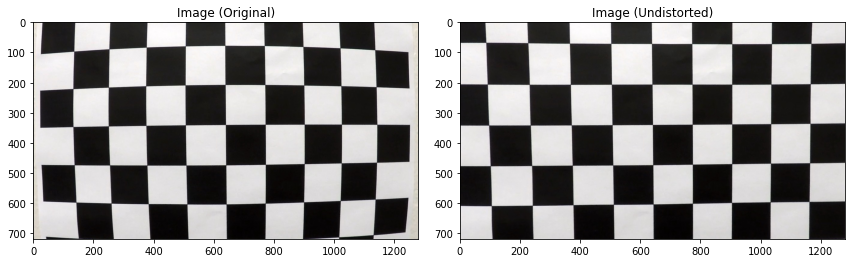

In [3]:
sample_camera_cal_img = mpimg.imread("camera_cal/calibration1.jpg")
sample_camera_cal_img_undist = cv2.undistort(sample_camera_cal_img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))
f.tight_layout()
ax1.imshow(sample_camera_cal_img)
ax1.set_title('Image (Original)')
ax2.imshow(sample_camera_cal_img_undist)
ax2.set_title('Image (Undistorted)')
plt.subplots_adjust()

## Explore (straight line images)

### Explore test image size

In [4]:
test_image_files = glob.glob("test_images/*.jpg")
for test_image_file in test_image_files:
    test_image = mpimg.imread(test_image_file)
    print(test_image.shape)

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


In [5]:
IMAGE_SIZE_X = 1280
IMAGE_SIZE_Y = 720

### An example of a distortion-corrected image

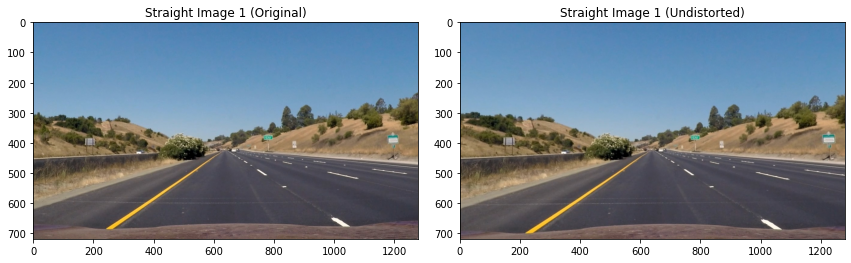

In [6]:
straight1 = mpimg.imread("test_images/straight_lines1.jpg")
straight1_undist = cv2.undistort(straight1, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))
f.tight_layout()
ax1.imshow(straight1)
ax1.set_title('Straight Image 1 (Original)')
ax2.imshow(straight1_undist)
ax2.set_title('Straight Image 1 (Undistorted)')
plt.subplots_adjust()

### An example of generate thresholded binary image

In [7]:
def grad_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobel = None
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    grad_binary = np.zeros_like(gray)
    grad_binary[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])] = 1
    return grad_binary

def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelxy = np.sqrt(sobelx ** 2 + sobely ** 2)
    scaled_sobelxy = np.uint8(255 * abs_sobelxy / np.max(abs_sobelxy))
    mag_binary = np.zeros_like(gray)
    mag_binary[(scaled_sobelxy > thresh[0]) & (scaled_sobelxy < thresh[1])] = 1
    return mag_binary

def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    direction = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(gray)
    dir_binary[(direction > thresh[0]) & (direction < thresh[1])] = 1
    return dir_binary

def hls_thresh(img, colorspace='s', thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    colorspace_index = {'h': 0, 'l': 1, 's': 2}[colorspace]
    colorspace = hls[:, :, colorspace_index]
    hls_binary = np.zeros_like(colorspace)
    hls_binary[(colorspace > thresh[0]) & (colorspace <= thresh[1])] = 1
    return hls_binary

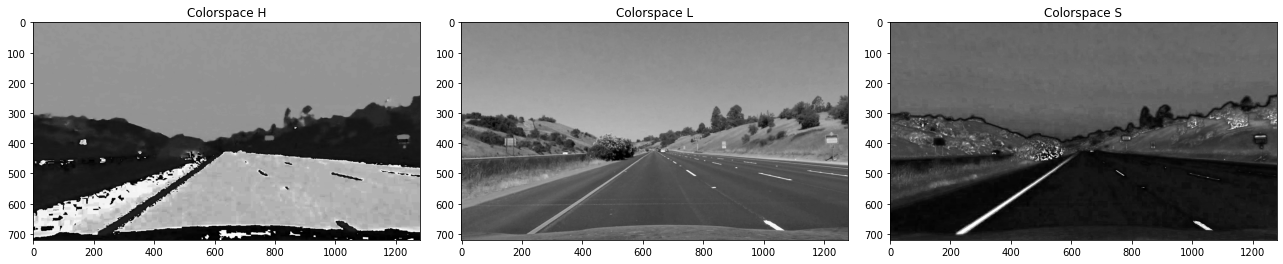

In [8]:
hls = cv2.cvtColor(straight1_undist, cv2.COLOR_RGB2HLS)
colorspace_h = hls[:,:,0]
colorspace_l = hls[:,:,1]
colorspace_s = hls[:,:,2]

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 7))
f.tight_layout()
ax1.imshow(colorspace_h, cmap='gray')
ax1.set_title('Colorspace H')
ax2.imshow(colorspace_l, cmap='gray')
ax2.set_title('Colorspace L')
ax3.imshow(colorspace_s, cmap='gray')
ax3.set_title('Colorspace S')
plt.subplots_adjust()

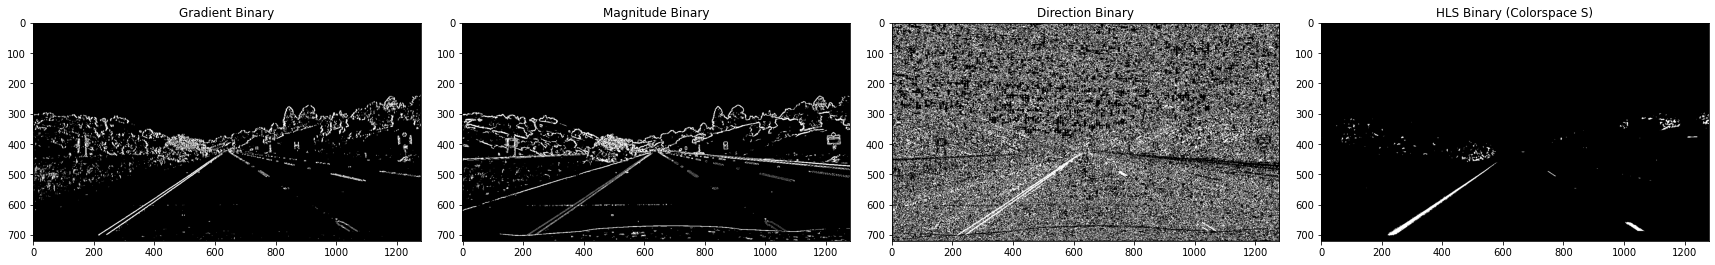

In [9]:
straight1_undist_grad = grad_thresh(straight1_undist, orient='x', sobel_kernel=3, thresh=(20, 100))
straight1_undist_mag = mag_thresh(straight1_undist, sobel_kernel=3, thresh=(30, 100))
straight1_undist_dir = dir_thresh(straight1_undist, sobel_kernel=3, thresh=(0.7, 1.3))
straight1_undist_hls = hls_thresh(straight1_undist, colorspace='s', thresh=(150, 255))

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 7))
f.tight_layout()
ax1.imshow(straight1_undist_grad, cmap='gray')
ax1.set_title('Gradient Binary')
ax2.imshow(straight1_undist_mag, cmap='gray')
ax2.set_title('Magnitude Binary')
ax3.imshow(straight1_undist_dir, cmap='gray')
ax3.set_title('Direction Binary')
ax4.imshow(straight1_undist_hls, cmap='gray')
ax4.set_title('HLS Binary (Colorspace S)')
plt.subplots_adjust()

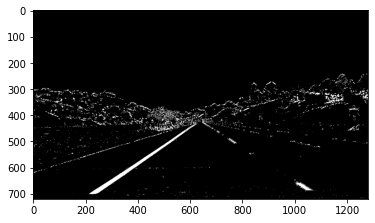

In [10]:
straight1_undist_gray = cv2.cvtColor(straight1_undist, cv2.COLOR_RGB2GRAY)
straight1_combined = np.zeros_like(straight1_undist_gray)
straight1_combined[((((straight1_undist_grad == 1) | (straight1_undist_mag == 1)) & (straight1_undist_dir == 1)) | (straight1_undist_hls == 1))] = 1
plt.imshow(straight1_combined, cmap='gray')

### An example of a transformed image

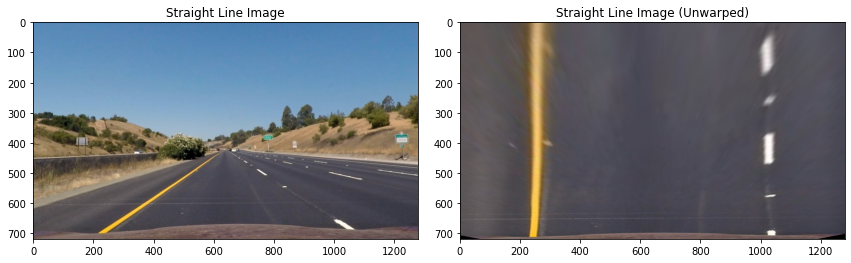

In [36]:
src = np.float32([(583, 457), (700, 457), (196, 720), (1113, 720)])
dst = np.float32([(240, 0), (1040, 0), (240, 720), (1040, 720)])
M = cv2.getPerspectiveTransform(src, dst)

straight1_undist_unwarp = cv2.warpPerspective(straight1_undist, M, (IMAGE_SIZE_X, IMAGE_SIZE_Y), flags=cv2.INTER_LINEAR)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))
f.tight_layout()
ax1.imshow(straight1_undist)
ax1.set_title('Straight Line Image')
ax2.imshow(straight1_undist_unwarp)
ax2.set_title('Straight Line Image (Unwarped)')
plt.subplots_adjust()

## Pipeline (test images)

In [12]:
# Required such parameters before CRITERIA.
# Camera Calibration: `mtx` `dist` (already calculated from camera calibration in the above)
# Perspective Transform: `M` (already calculated from straight line in the above)

# Define Meters per Pixel
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

### CRITERIA 1

*Distortion Correct* 

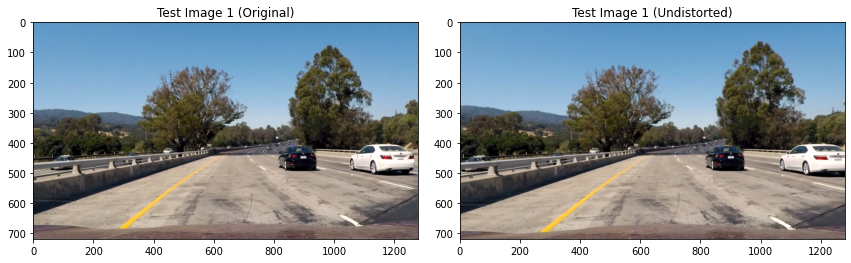

In [13]:
test1 = mpimg.imread("test_images/test1.jpg")
test1_undist = cv2.undistort(test1, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))
f.tight_layout()
ax1.imshow(test1)
ax1.set_title('Test Image 1 (Original)')
ax2.imshow(test1_undist)
ax2.set_title('Test Image 1 (Undistorted)')
plt.subplots_adjust()

### CRITERIA 2

*Thresholded Binary*

In [14]:
def region_of_interest(img, vertices_ratio=((0.0, 0.0), (0.0, 1.0), (1.0, 0.0), (1.0, 1.0))):

    y_max, x_max = img.shape[0] - 1, img.shape[1] - 1
    vertices = np.array([[(x_max*vertices_ratio[0][0], y_max*vertices_ratio[0][1]),
                          (x_max*vertices_ratio[1][0], y_max*vertices_ratio[1][1]),
                          (x_max*vertices_ratio[2][0], y_max*vertices_ratio[2][1]),
                          (x_max*vertices_ratio[3][0], y_max*vertices_ratio[3][1])]]).astype(int)
    mask = np.zeros_like(img)   
    
    if len(img.shape) > 2:
        channel_count = img.shape[-1]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    
    return masked_image

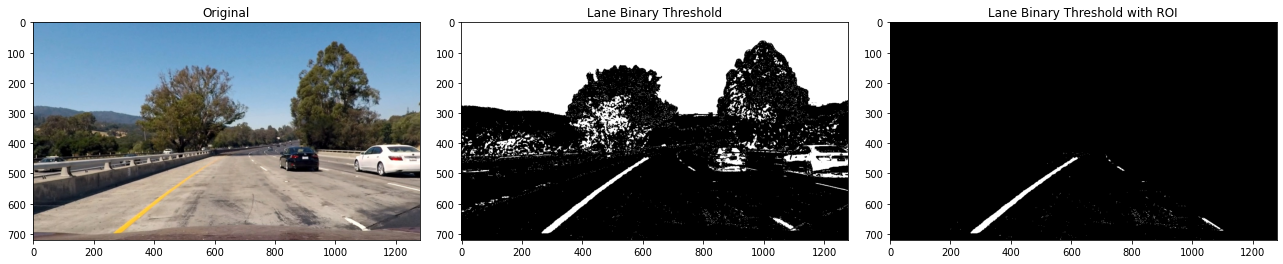

In [34]:
def generate_lane_threshold(img):
    img_grad = grad_thresh(img, orient='x', sobel_kernel=3, thresh=(20, 100))
    img_dir = dir_thresh(img, sobel_kernel=3, thresh=(0.9, 1.1))
    img_mag = mag_thresh(img, sobel_kernel=3, thresh=(30, 100))
    img_hls = hls_thresh(img, colorspace='s', thresh=(100, 255))
    
    img_combined_binary = np.zeros((img.shape[0], img.shape[1]))
    img_combined_binary[((((img_grad == 1) | (img_mag == 1)) & (img_dir == 1)) | (img_hls == 1))] = 1
    return img_combined_binary

test1_undist_lane_threshold = generate_lane_threshold(test1_undist)
test1_undist_lane_threshold_roi = region_of_interest(test1_undist_lane_threshold, vertices_ratio=((0.1, 1.0), (0.45, 0.6), (0.55, 0.6), (0.9, 1.0)))

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 7))
f.tight_layout()
ax1.imshow(test1_undist)
ax1.set_title('Original')
ax2.imshow(test1_undist_lane_threshold, cmap='gray')
ax2.set_title('Lane Binary Threshold')
ax3.imshow(test1_undist_lane_threshold_roi, cmap='gray')
ax3.set_title('Lane Binary Threshold with ROI')
plt.subplots_adjust()

### CRITERIA 3

*Perspective transform and provide an example of a transformed image.*

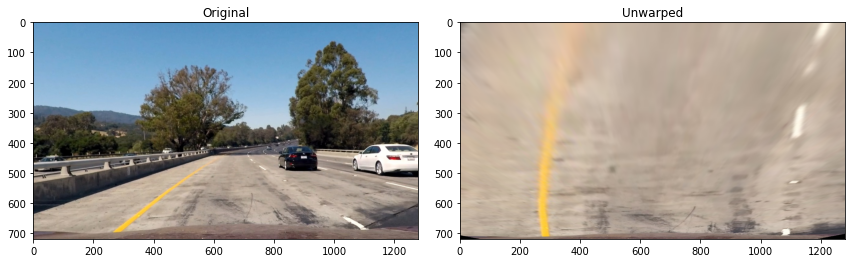

In [35]:
def generate_upwarp(img, M):
    return cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

test1_undist_unwarp = generate_upwarp(test1_undist, M)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))
f.tight_layout()
ax1.imshow(test1_undist)
ax1.set_title('Original')
ax2.imshow(test1_undist_unwarp)
ax2.set_title('Unwarped')
plt.subplots_adjust()

### CRITERIA 4

*Lane-line Pixels with Polynomial*

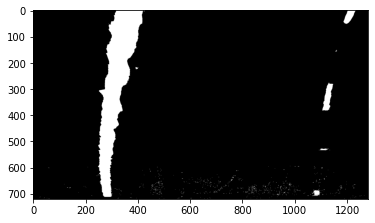

In [17]:
test1_undist_unwarp_lane_threshold = generate_lane_threshold(test1_undist_unwarp)
plt.imshow(test1_undist_unwarp_lane_threshold, cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


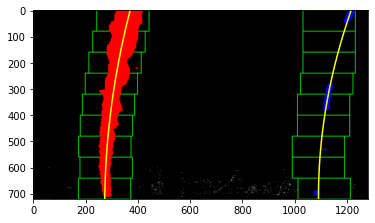

In [18]:
def find_lane_pixels(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    nwindows = 9
    margin = 100
    minpix = 50

    window_height = np.int(binary_warped.shape[0]//nwindows)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base

    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        pass

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped, plot_polynomial=True):
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    if plot_polynomial:
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fit, right_fit


out_img, left_fit, right_fit = fit_polynomial(test1_undist_unwarp_lane_threshold)

plt.imshow(out_img)

### CRITERIA 5

*radius of curvature, position of the vehicle*

In [19]:
def measure_curvature_and_distance(binary_warped, xm_per_pix, ym_per_pix):
    
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    
    left_fit = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    y_eval = np.max(ploty) * ym_per_pix
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    # Calculation of  x (value of the middle of two lanes)
    lane_middle_x = (left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2] + right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]) / 2
    car_middle_x = int(IMAGE_SIZE_X//2) * xm_per_pix
    distance_to_middle = car_middle_x - lane_middle_x
    
    return left_curverad, right_curverad, distance_to_middle

left_curverad, right_curverad, distance_to_middle = measure_curvature_and_distance(test1_undist_unwarp_lane_threshold, xm_per_pix, ym_per_pix)

print('LeftCurv: {:.2f}m, RightCurv: {:.2f}m\nDistance to Middle: {:.2f}m'.format(left_curverad, right_curverad, distance_to_middle))

LeftCurv: 963.30m, RightCurv: 670.47m
Distance to Middle: -0.22m


### CRITERIA 6

*result back to original image*

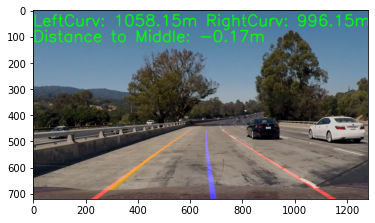

In [20]:
def generate_detected_image(img, mtx, dist, M):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    undist_lane_threshold = generate_lane_threshold(undist)
    undist_lane_threshold_roi = region_of_interest(undist_lane_threshold, vertices_ratio=((0.1, 1.0), (0.45, 0.6), (0.55, 0.6), (0.9, 1.0)))
    undist_unwarp_lane_threshold_roi = generate_upwarp(undist_lane_threshold_roi, M)
    _, left_fit, right_fit = fit_polynomial(undist_unwarp_lane_threshold_roi, plot_polynomial=False)
    
    lane_unwarp = np.zeros_like(img)

    ploty = np.linspace(0, img.shape[0]-1, img.shape[0]).astype(int)
    left_fitx = (left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]).astype(int)
    right_fitx = (right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]).astype(int)
    lane_middle_x = (left_fitx + right_fitx) // 2
    car_x = img.shape[1] // 2
    car_y = img.shape[0] - 1

    lane_padding = 10
    for i in range(-lane_padding, lane_padding+1, 1):
        try:
            lane_unwarp[ploty, left_fitx+i] = [255, 0, 0]
            lane_unwarp[ploty, right_fitx+i] = [255, 0, 0]
            lane_unwarp[ploty, lane_middle_x+i] = [0, 0, 255]
        except Exception:
            pass

    lane_undist = cv2.warpPerspective(lane_unwarp, np.linalg.inv(M), (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

    detected_image = cv2.addWeighted(img, 0.8, lane_undist, 1.0, 0.0)
    
    left_curverad, right_curverad, distance_to_middle = measure_curvature_and_distance(undist_unwarp_lane_threshold_roi, xm_per_pix, ym_per_pix)
    
    annotation_curvature = 'LeftCurv: {:.2f}m RightCurv: {:.2f}m'.format(left_curverad, right_curverad)
    annotation_distance = 'Distance to Middle: {:.2f}m'.format(distance_to_middle)
    detected_image = cv2.putText(detected_image, annotation_curvature, (0,60), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,255,0),3,cv2.LINE_AA)
    detected_image = cv2.putText(detected_image, annotation_distance, (0,120), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,255,0),3,cv2.LINE_AA)
    
    return detected_image

plt.imshow(generate_detected_image(test1, mtx, dist, M))

In [21]:
### Sum all above and generate output

OUTPUT_DIR = "output_images"

for image_file in glob.glob("test_images/test*.jpg"):
    input_img = mpimg.imread(image_file)
    output_image = generate_detected_image(input_img, mtx, dist, M)
    output_image_file_name = image_file.split('/')[-1].replace(".jpg", "-output.jpg")
    mpimg.imsave(OUTPUT_DIR + '/' + output_image_file_name, output_image)

## Pipeline (video)

In [23]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = generate_detected_image(image, mtx, dist, M)
    return result

In [24]:
challenge_output = 'challenge_video-output.mp4'

clip = VideoFileClip("challenge_video.mp4")
challenge_clip = clip.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

t:   0%|          | 0/485 [00:00<?, ?it/s, now=None]

Moviepy - Building video challenge_video-output.mp4.
Moviepy - Writing video challenge_video-output.mp4



Moviepy - Done !
Moviepy - video ready challenge_video-output.mp4
CPU times: user 3min 28s, sys: 36.7 s, total: 4min 5s
Wall time: 3min 26s


In [25]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">|
</video>
""".format(challenge_output))